# FGS Spelunker Quickstart

---
**Authors:** Derod Deal (dealderod@ufl.edu), Néstor Espinoza (nespinoza@stsci.edu) | **Last update:** July 18, 2023

**Program version:** ver. 0.5.3

The JWST telescope carries four different instruments: NIRCam, NIRSpec, MIRI, and the Fine Guidance Sensor (FGS). FGS Spelunker is a package designed to conveniently analyze guidestar data. In this notebook, we cover the following main functions of this package.


1. [Getting started](#getting-started)
    - Installation
    - Using `fgs_splelunker`
2. [Downloading data](#downloading-data)
3. Spatial fitting guide stars
    - [Gaussian fitting](#gaussian-fitting)
    - [Quick fitting](#quick-fitting)
4. [Plotting parameters](#plotting-parameters)
5. Periodograms
    - [Creating a periodogram](#periodogram)
    - [Creating a periodogram comparison plot](#periodogram_list_plot)
    - [Timeseries—Periodogram insets](#periodogram_timeseries_inset_plot)
6. [Mnemonics](#mnemonics)
7. [Animations](#animations)
8. [Getting tables](#getting-tables)

# Getting started

To get started with FGS Spelunker, first call `fgs_spelunker` into a variable while setting a directory and a given proposal id.

In [1]:
import sys
sys.path.append('/Users/ddeal/JWST-FGS-Spelunker/JWST-FGS-Spelunker-main/')

import Spelunker

spk = Spelunker.load('/Users/ddeal/JWST-Treasure-Chest/',) # Calling the load method with only your directory initializes the class

## Downloading data

To load Spelunker with a given Program ID for JWST, simply call `Spelunker.load` with the Program ID as a parameter.

In [2]:
spk = Spelunker.load('/Users/ddeal/JWST-Treasure-Chest/', pid='1534', obs_num='1', visit='1') 

INFO: Found cached file ./mastDownload/JWST/jw01534001001_03101_00001_guider1/jw01534001001_gs-fg_2022340000825_cal.fits with expected size 9388800. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534001001_03101_00001_guider1/jw01534001001_gs-fg_2022340002102_cal.fits with expected size 7827840. [astroquery.query]


To download the data after initialization, use `spk.download()` with given proposal id with the optional parameters observation number `obs_num` and visit number `visit`. You can also set the calibration level `calib_level`. This information are required to use `astroquery.mast` to search and download the necessary files. The download function will download the selected files in the given directory and create a 2D array of the guidestar data as well as an array of time and a flux timeseries. The same parameters work with `Spelunker.load`.

In [3]:
spk.download('2589', obs_num='2',) # calib_level will default to 2 if not specified

After we downloaded our data, we can access preprocessed spatial, time, and flux arrays for all FITS files images under the specified Program ID. Use the attributes `spk.fg_array`, `spk.fg_time`, and `spk.fg_flux` to access the arrays.

In [ ]:
fg_array_2589, fg_time_2589, fg_flux_2589 = spk.fg_array, spk.fg_time, spk.fg_flux

In [ ]:
spk.fg_array.shape, spk.fg_time.shape, spk.fg_flux.shape

((550767, 8, 8), (550767,), (550767,))

Previously downloaded FITS files in a given directory will not be re-downloaded. If there are multiple files downloaded for the given parameter, `spk.download` will automatically stitch the data from the files into an array based on the date and time for each file, along with the time and flux arrays. 

In [ ]:
spk.download('1534', obs_num='1', visit='1',)

2023-07-18 11:10:56,217 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534001001_03101_00001_guider1/jw01534001001_gs-fg_2022340000825_cal.fits with expected size 9388800.
2023-07-18 11:10:56,272 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534001001_03101_00001_guider1/jw01534001001_gs-fg_2022340002102_cal.fits with expected size 7827840.


INFO: Found cached file ./mastDownload/JWST/jw01534001001_03101_00001_guider1/jw01534001001_gs-fg_2022340000825_cal.fits with expected size 9388800. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534001001_03101_00001_guider1/jw01534001001_gs-fg_2022340002102_cal.fits with expected size 7827840. [astroquery.query]


In [ ]:
spk.fg_time.shape,  spk.fg_flux.shape

((16894,), (16894,))

FGS Spelunker can also handle single fits files already stored locally by using:

In [ ]:
spk.readfile('/Users/ddeal/Spelunker-older/JWST-Treasure-Chest-2023/mastDownload/JWST/jw01534001001_03101_00001_guider1/jw01534001001_gs-fg_2022340000825_cal.fits')

In [ ]:
spk.fg_time.shape, spk.fg_flux.shape

((9214,), (9214,))

> Currently, `spk.readfile()` does not support the folling attributes: 
> - `fg_table`, 
> - `object_properties`.

## Spatial fitting guide stars

After downloading the data, we can perform spatial fitting gaussians to each frame in a guidestar timeseries. This uses parallel processing through `ray` to speed up the process. We can also perform quick fits to speed through a given timeseries, though this method is a lot less accurate in the fitting.

### Gaussian fitting

The downloaded data comes as a spatial timeseries of a selected guidestar. To measure the centriods and PSF width of each frame, we need to apply fitting. We will use Gaussian spatial fitting to measure x and y pixel coordinates, x and y standard deviations, thetha, and the offset. We will use the following derivation for fitting the guidestar frames: 

$$\large f(x,y) = A \exp \left(-\left(a(x-x_0)^2 + 2b(x-x_0)(y-y_0) + c(y-y_0)^2\right)\right) + \text{offset,}$$

where $\large a = \frac{\cos^2 \theta}{2 \sigma^2_X} + \frac{\sin^2 \theta}{2\sigma^2_Y} $, $ \large b = \frac{\sin 2\theta}{4 \sigma^2_X} + \frac{\sin 2\theta}{4\sigma^2_Y}$, and $ \large  c = \frac{\sin^2 \theta}{2 \sigma^2_X} + \frac{\cos^2 \theta}{2\sigma^2_Y}$ (https://en.wikipedia.org/wiki/Gaussian_function). To perform spatial gaussian fitting, use `gauss2d_fit` with guidestar arrays (the timeseries needs to be in an 8 by 8 array, which should be the same for all guidestar fine guidence products).

In [ ]:
fg_array_2589_short = fg_array_2589[0:1000] # Processing spatial Gaussians for each frame can require a long duration of time, so we will limit the number of frames in an array

table_gauss_fit = spk.gauss2d_fit(fg_array_2589_short, ncpus=12) # ncpus sets the number of cpu cores your computer has. Defaults to 4 cores.

NameError: name 'fg_array_2589' is not defined

The `gauss2d_fit` function outputs an astropy table, which can bee accessed with the `spk.gaussfit_results` attribute.

In [ ]:
spk.gaussfit_results

amplitude,x_mean,y_mean,x_stddev,y_stddev,theta,offset
float64,float64,float64,float64,float64,float64,float64
91.37426787326334,3.374125011269659,2.91233492989653,0.6650899668447264,0.5788702634900186,0.3920767833547233,-0.6181134866343163
84.5758695852238,3.365625323270138,2.8750423830836938,0.6806098204840507,0.5975911430716024,0.27945661606754457,-0.13238111925017135
96.6545394598683,3.348375369077728,2.8888615752540714,0.6278629843436604,0.5711213763144364,0.7213164213927089,1.7714385564888822
87.33604290057181,3.3532304224337293,2.915357716321448,0.6406151255870217,0.5919943426426871,0.37081871174972997,-0.3149507363760289
88.31596660155532,3.346261870211958,2.9020722939975587,0.6669729366510705,0.6009648579844599,0.38207254342459435,0.7068734567543502
94.55498330339346,3.377820294098894,2.8472246113453865,0.6457637443071612,0.5531431931621802,0.4880242240377736,0.875665024966833
85.12163910220147,3.355859461508177,2.8517247353492015,0.6869913873614045,0.591560272664991,0.5308779554639291,-0.836940447468064
89.1183524642835,3.327025147976626,2.8819178365174034,0.6635714729285936,0.5680142382393396,0.6393507507997723,-0.14835449576372225
90.6239809055793,3.3606614973281026,2.8758528090107163,0.6822994757891044,0.5686514527861877,0.4825375164717419,1.0440165404707646


### Quick fitting

There are some situations where you need to quickly obtain rough statistics of changes in guidestar products overtime. Quick fitting fits the x and y pixel locations and standard deviations as an astropy table using centroid and variance calculations. To perform quick fitting, run `quick_fit` with an appropriate array.

In [ ]:
table_quick_fit = spk.quick_fit(fg_array_2589_short)

/Users/ddeal/JWST-Treasure-Chest-2023/JWST-FGS-Spelunker-Repos/JWST-FGS-Spelunker/Spelunker.py:622: RuntimeWarning: invalid value encountered in sqrt
  return centroid, np.sqrt(variance)


In [ ]:
spk.quickfit_results

amplitude,x_mean,y_mean,x_stddev,y_stddev,theta,offset
float32,float64,float64,float64,float64,int64,int64
77.410286,2.5371975104390443,2.692586796556106,2.6389348839227535,2.4717049334727035,0,0
72.88121,3.9086635563267165,-0.032502648169332904,1.4543203508501603,0.0,0,0
83.69554,3.719452345469883,4.772637124027121,2.445721284948712,2.0753978086226987,0,0
75.00711,2.957945364309977,4.689013994618828,2.4149213392734468,2.362576673273771,0,0
77.91866,-18.878666816873906,-2.0233091340170435,0.0,0.0,0,0
78.842964,2.5223282861811693,5.8660999705491905,0.0,0.0,0,0
72.46527,4.433139175262253,2.339820081554779,2.772881677536729,2.4430465700154476,0,0
78.47324,2.810129978393008,2.899539025749678,2.6309012993602443,2.2159339550991093,0,0
79.351326,-5.711003755956468,3.6434409493072955,0.0,0.0,0,0


## Plotting parameters

We can plot a timeseries of a given parameter or flux from guidestars. The method `timeseries_binned_plot` will generate a matplotlib axes object of a given timeseries.

(0.0, 2.0)

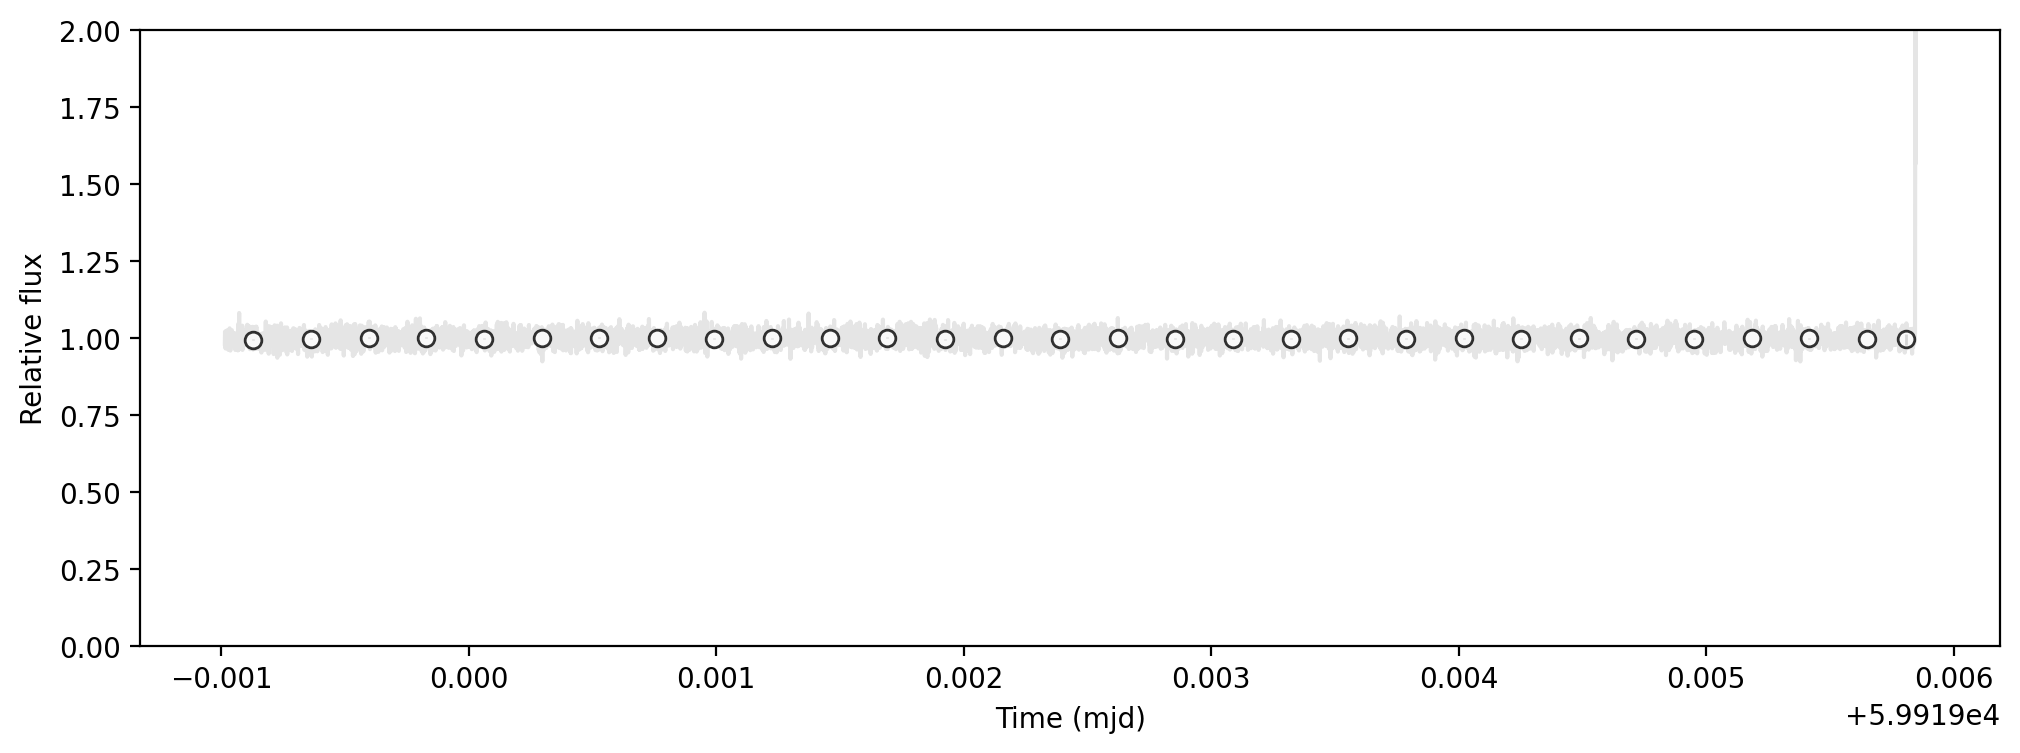

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12,4), dpi=200)

ax = spk.timeseries_binned_plot(spk.fg_time, spk.fg_flux)
ax.set_ylim(0, 2)

In [ ]:
spk.fg_time.shape, spk.fg_flux.shape

((9214,), (9214,))

Within guidestar data, changes in the PSF can impact the observed flux of the star. Certain events might see changes in all fitted parameters. In this case, subplots of each parameter will provide more information to the user about the event, giving them the change of guidestar position, brightness, and FWHM overtime. 

In [ ]:
fg_time_2589_short = fg_time_2589[10000:11000]
fg_array_2589_short = fg_array_2589[10000:11000]

table_gauss2d_fit_short = spk.gauss2d_fit(fg_array_2589_short, ncpus=12)

2023-07-18 11:11:19,259	INFO worker.py:1636 -- Started a local Ray instance.


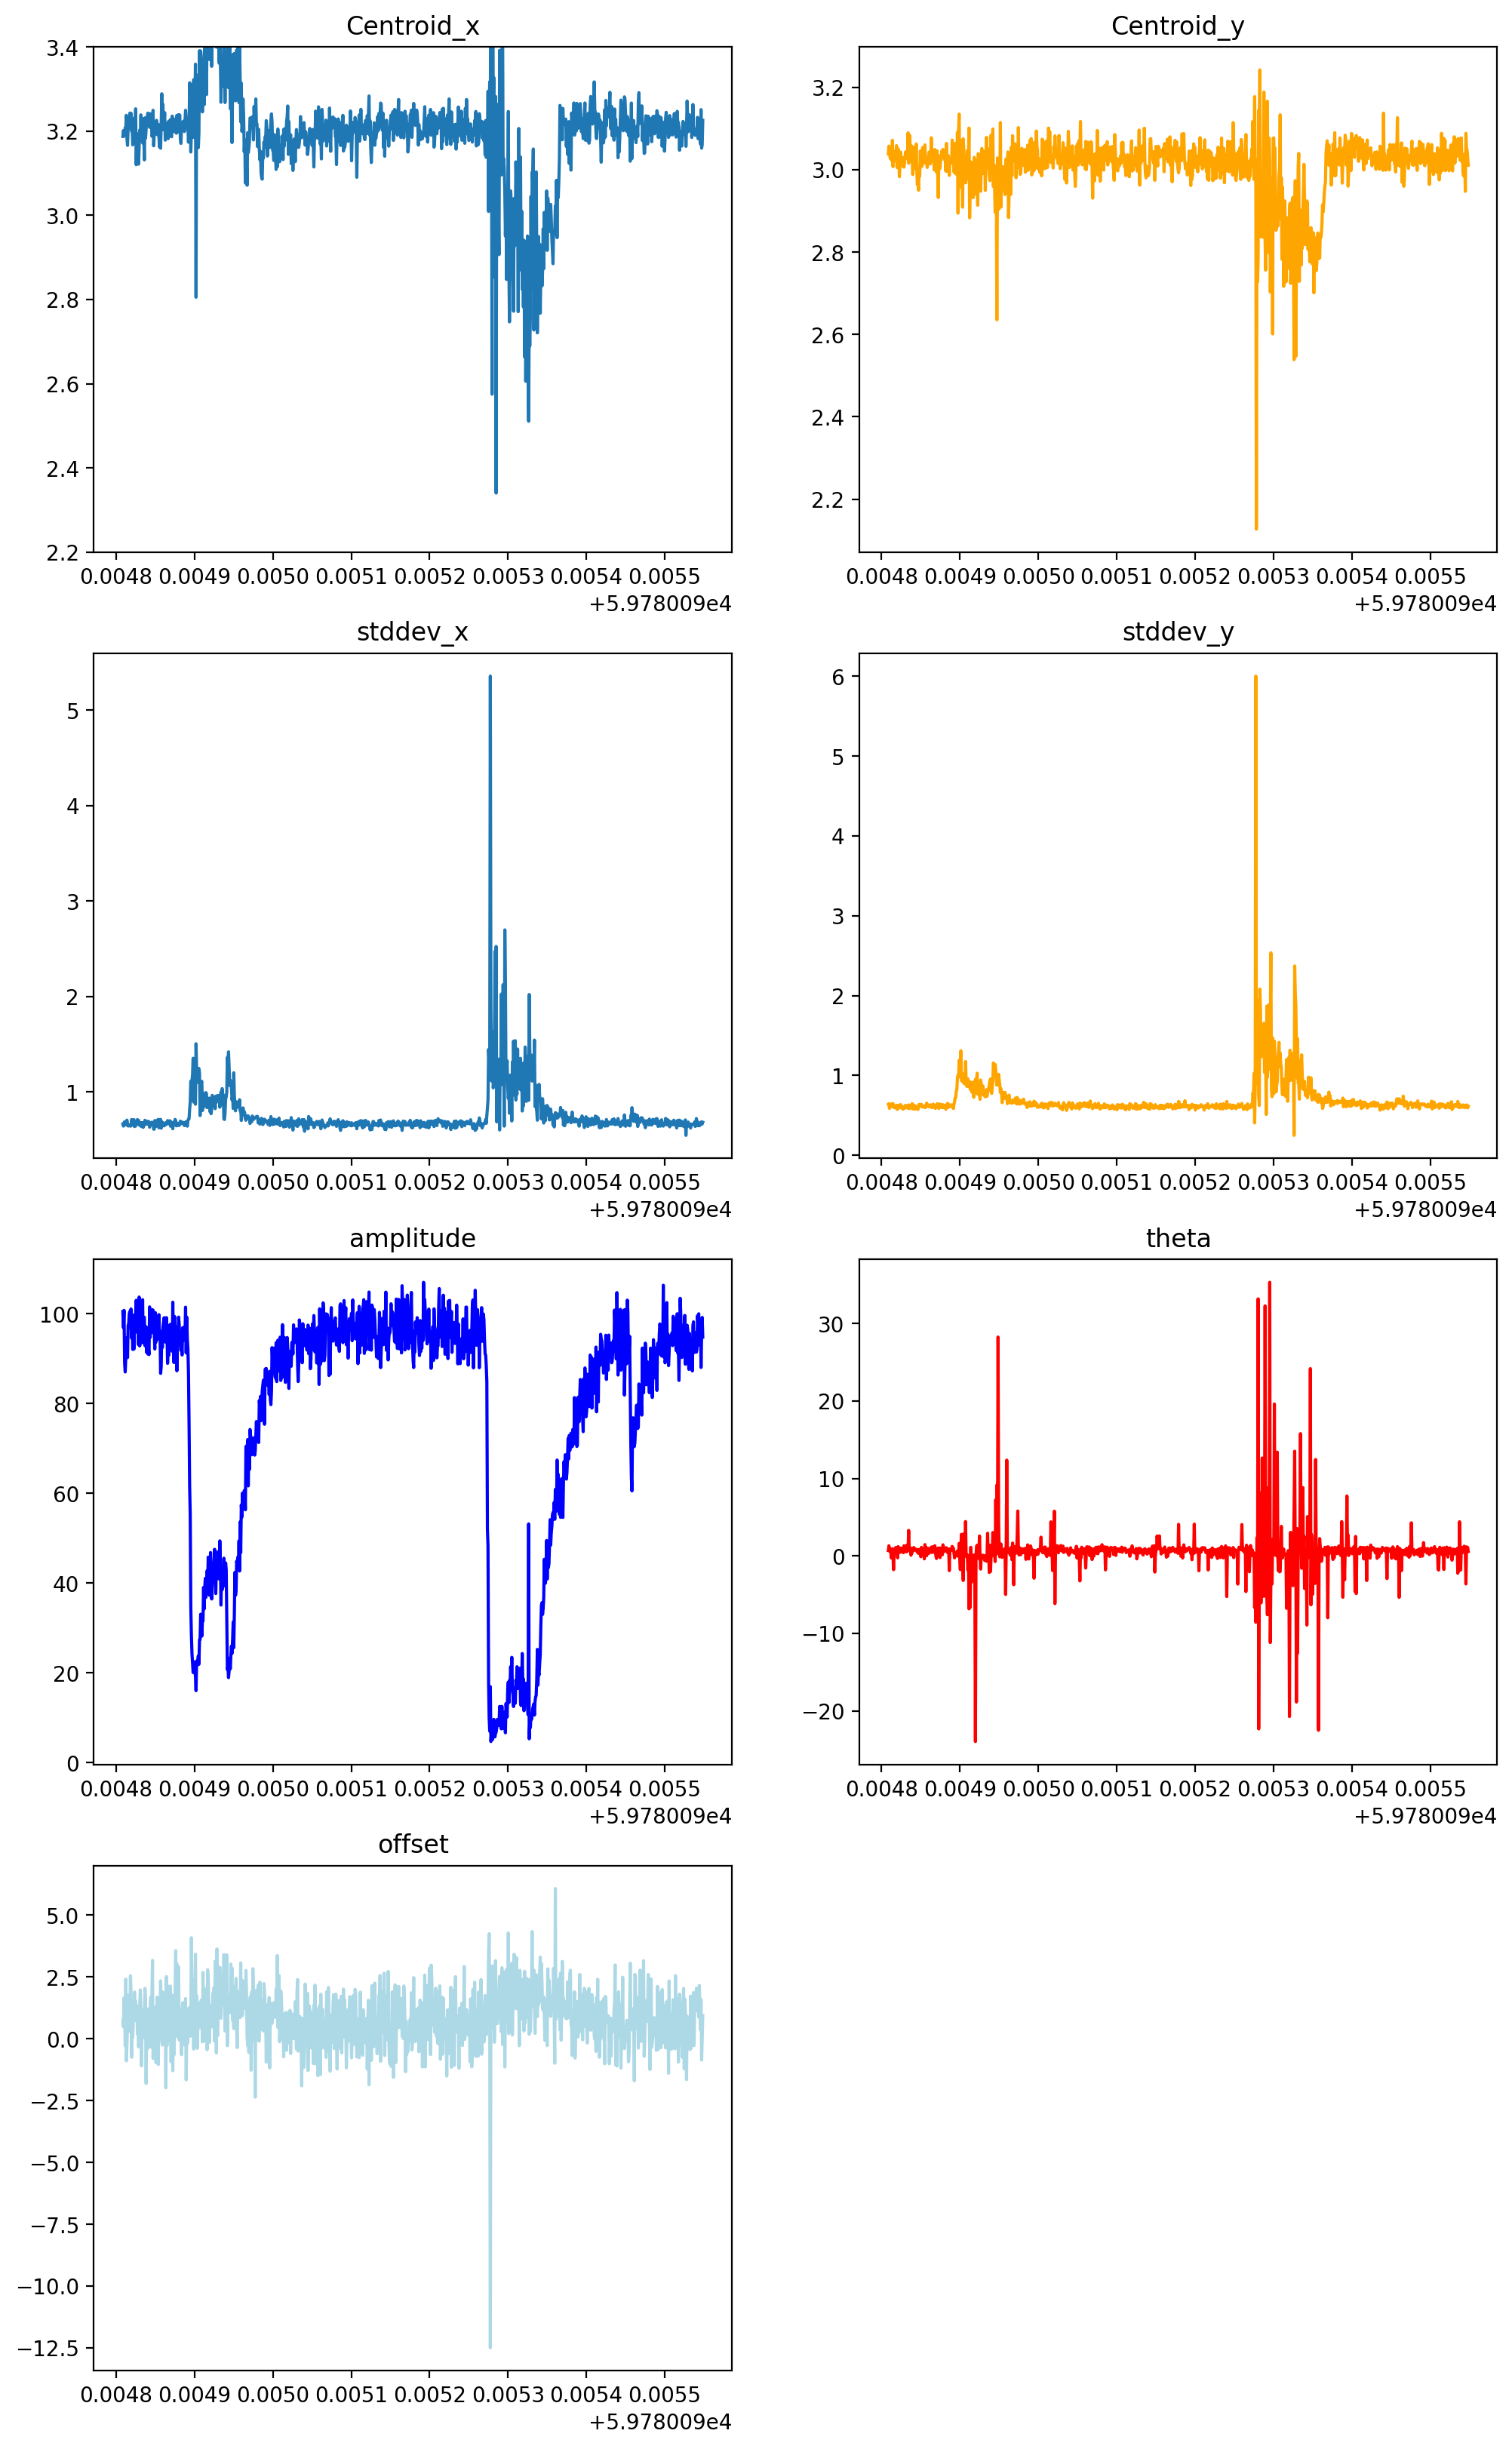

In [ ]:
ax = spk.timeseries_list_plot(table_gauss2d_fit_short, fg_time_2589_short)

## Periodograms

FGS Spelunker comes with various tools to visualize and explore guidestar data. Periodograms are useful for guidestar products to detect periodicities not only within flux timeseries, but also within centroids, FWHM, theta, and offset. From a selected fitting method, we can use the table output to apply Lomb-Scargle periodograms to our parameters.

### `periodogram`

To obtain the power and frequencies of Lomb-Scargle periodograms for each fitted parameter, use `periodogram`. The periodograms for each given parameter from a fit can be conveniently plotted in a single figure with the same method.

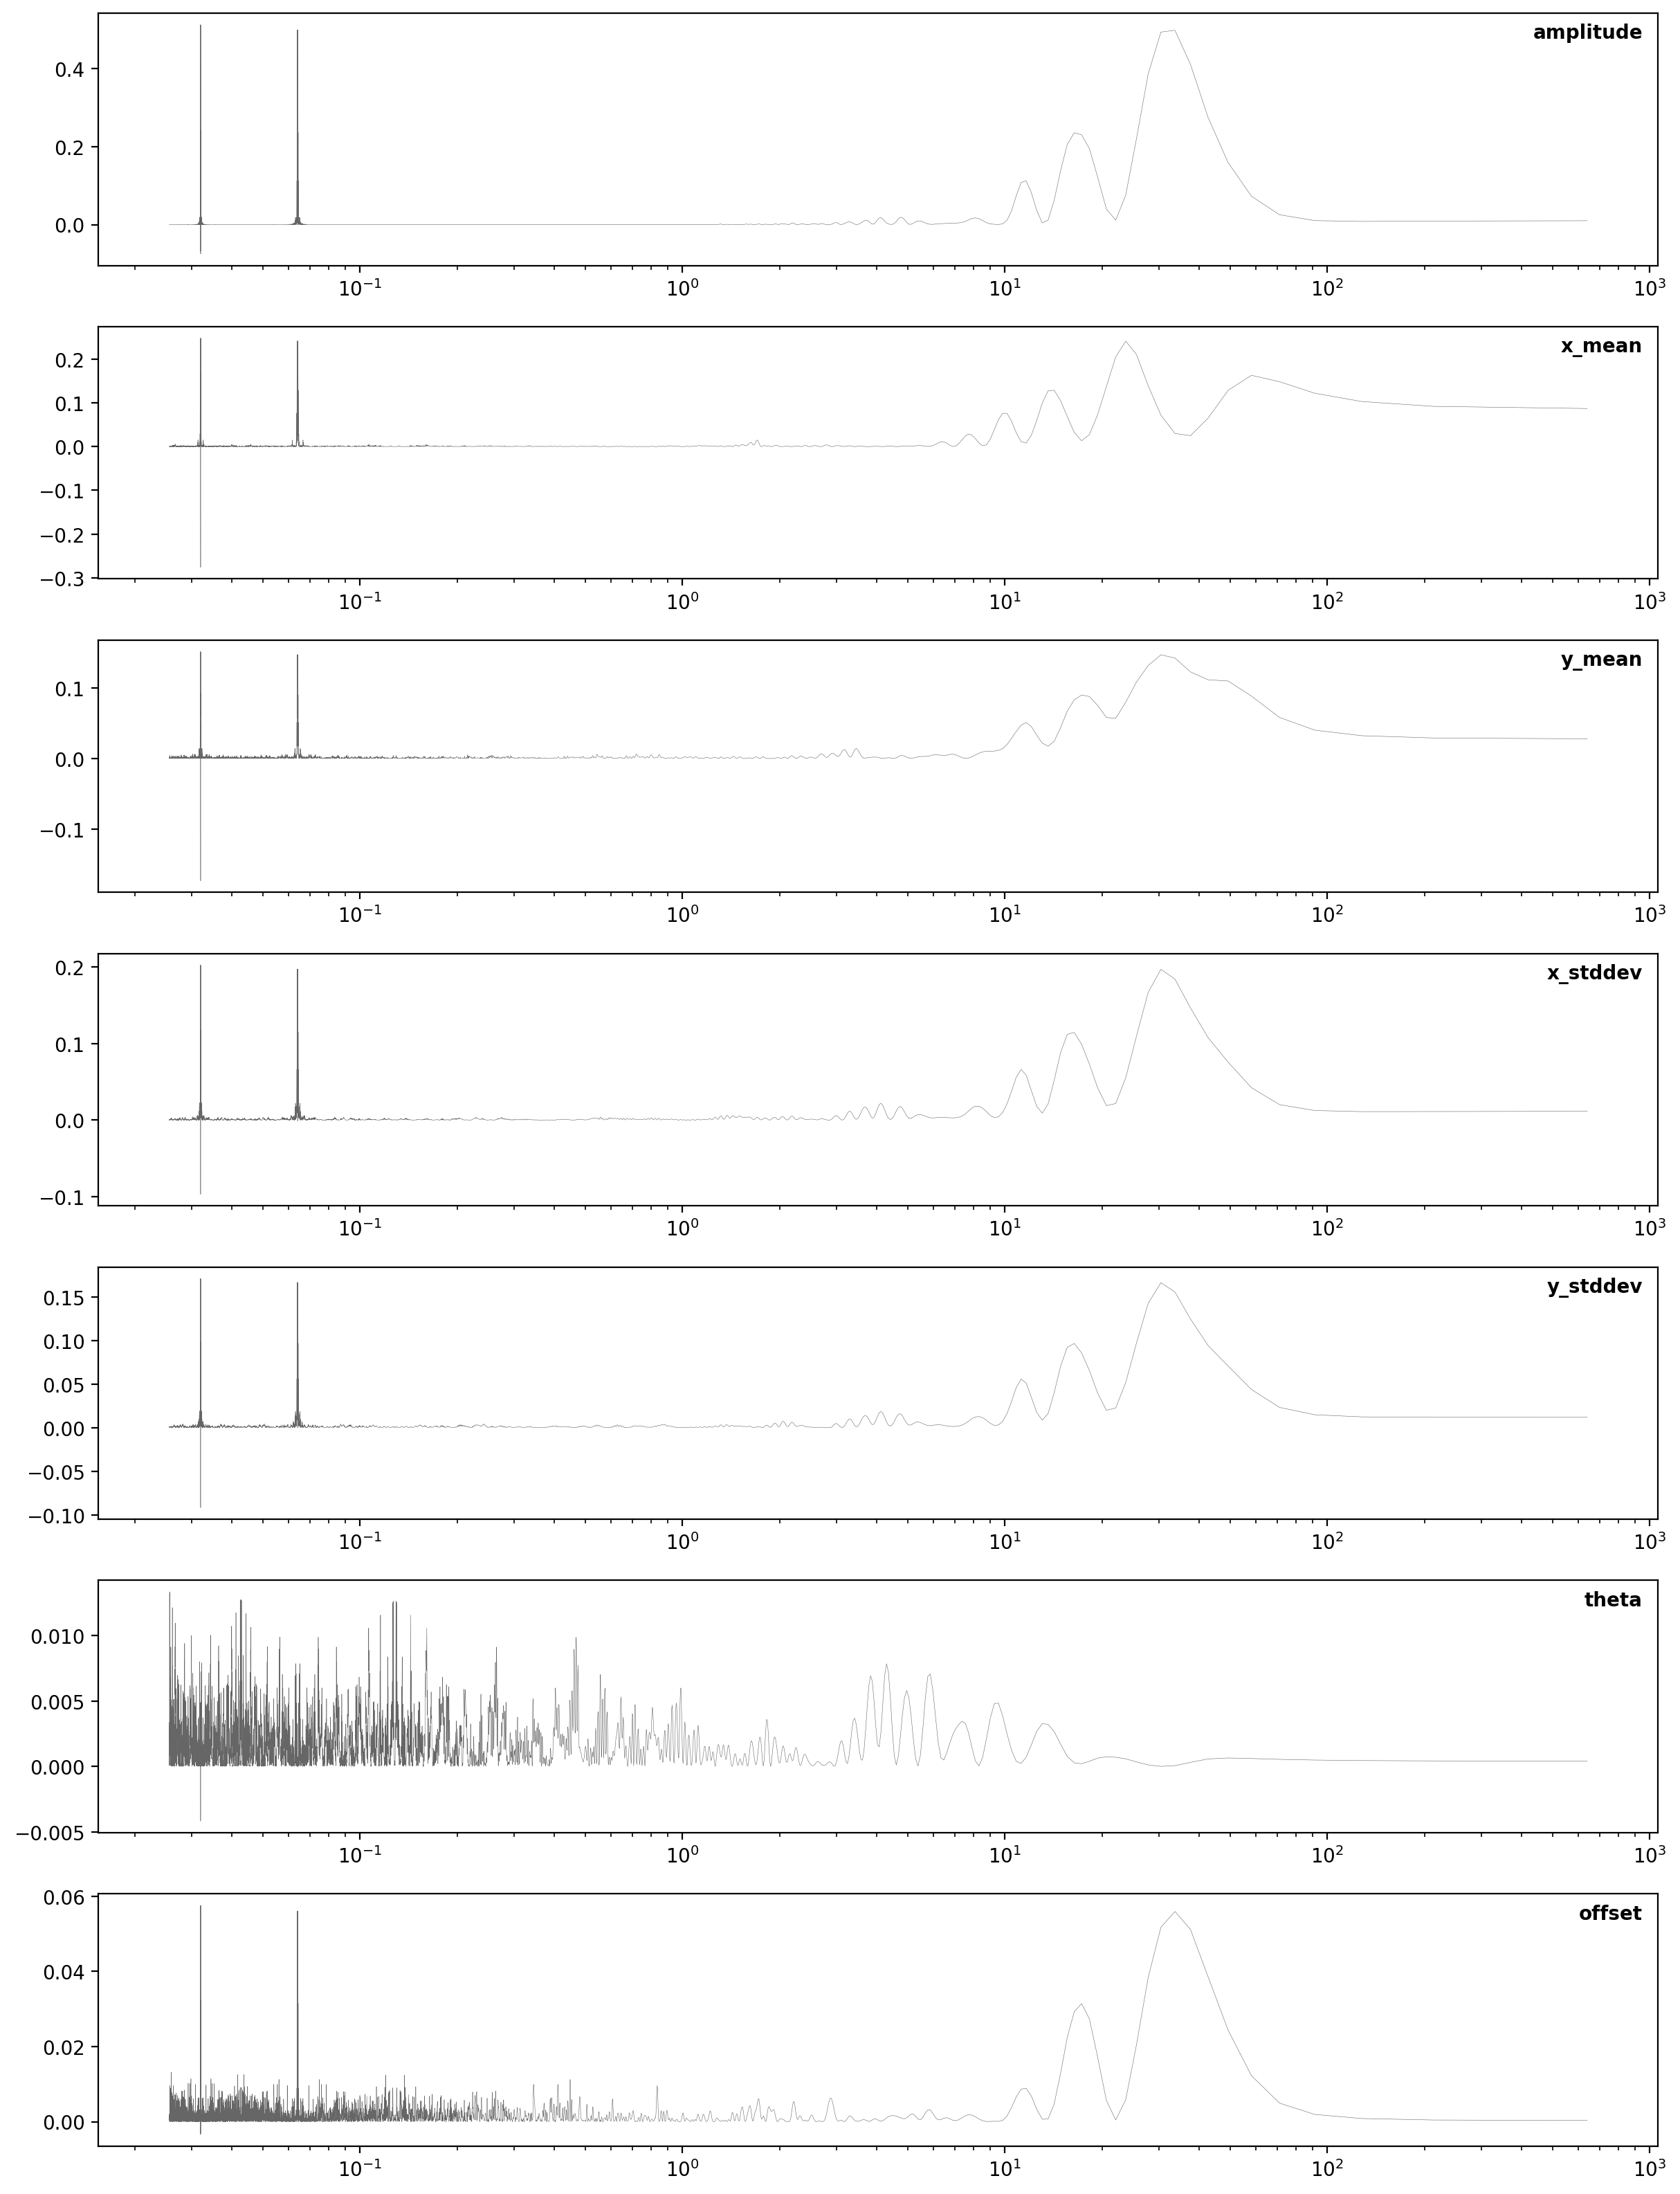

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

In [ ]:
spk.periodogram(spk.gaussfit_results, spk.fg_time[0:1000])

To get the frequency and power for each fitted parameter, use `spk.pgram_{parameter}`.
> Available parameters:
> - `spk.pgram_amplitude`
> - `spk.pgram_x_mean`
> - `spk.pgram_y_mean`
> - `spk.pgram_x_stddev`
> - `spk.pgram_y_stddev`
> - `spk.pgram_theta`
> - `spk.pgram_offset`

In [ ]:
freq = spk.pgram_x_mean[0] # periodogram frequency
power = spk.pgram_x_mean[1] # periodogram power

## Mnemonics

When observing the timeseries of the guidestar, there might be technical events from the JWST that causes changes in obtained data. For example, high gain antenna or filter changes in NIRCAM can cause noticeable changes in flux or other guidestar properties. We can overlay these events onto fitted parameters using `mnemonics` and `mnemonics_plot`.

> Current supported mnemonics: *SA_ZHGAUPST*, *INIS_FWMTRCURR*


<Axes: >

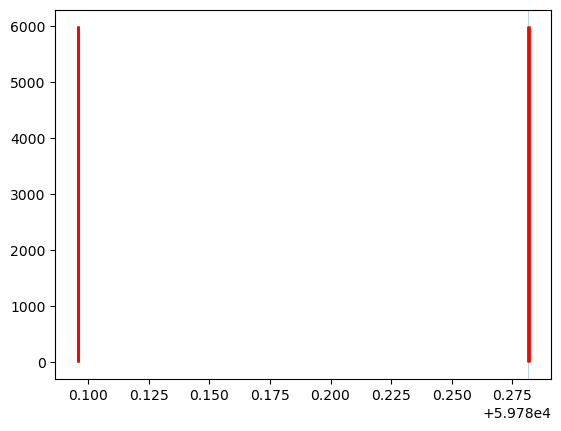

In [ ]:
spk.mast_api_token = '8eedd0a371a44e598a9c4489e3148811'
spk.mnemonics('SA_ZHGAUPST', fg_time_2589[0], fg_time_2589[-1])

For plotting and overlaying mnemonic events on matplotlib figures, use `mnemonics_plot`.

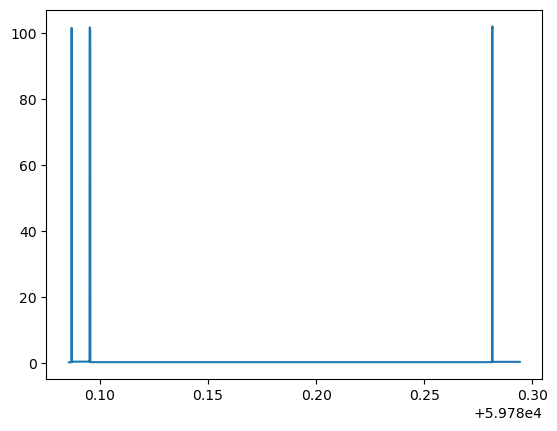

In [ ]:
ax = spk.mnemonics('INIS_FWMTRCURR', fg_time_2589[0], fg_time_2589[-1])

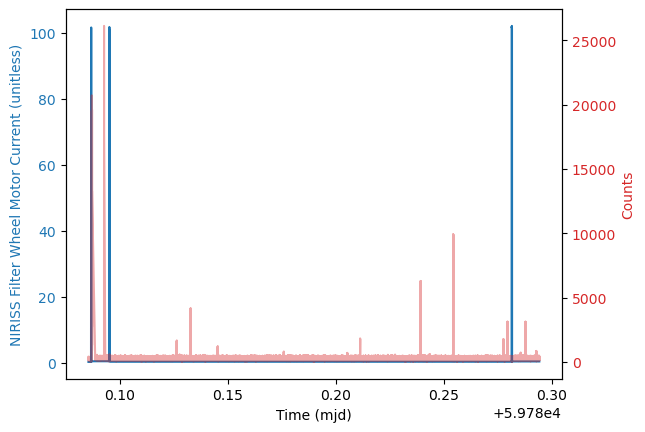

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(dpi=100)

ax1 = spk.mnemonics('INIS_FWMTRCURR', fg_time_2589[0], fg_time_2589[-1])

#ax3 = spk.mnemonics_plot('SA_ZHGAUPST', fg_time_2589[0], fg_time_2589[-1])
color = 'tab:blue'
ax1.set_xlabel('Time (mjd)')
ax1.set_ylabel('NIRISS Filter Wheel Motor Current (unitless)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Counts', color=color)  # we already handled the x-label with ax1
ax2.plot(fg_time_2589, fg_flux_2589, color=color, alpha = 0.4)
ax2.tick_params(axis='y', labelcolor=color)

#plt.xlim(59780.0865, 59780.088)
plt.show()

## Animations

Spatial data of guidestar imaging can bring essential information about how the point spread function changes overtime. Animations of the spatial timeseries are convenient and helpful methods to analyze guidestar data.

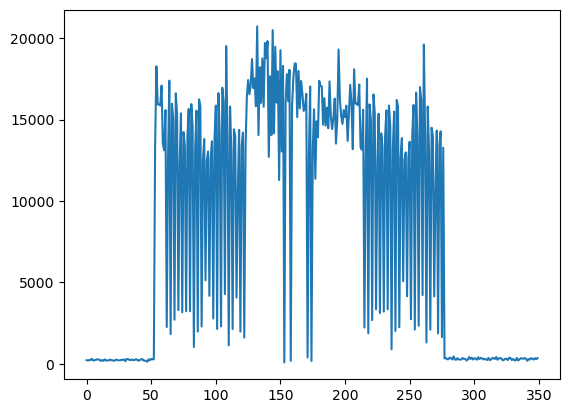

In [ ]:
plt.plot(fg_flux_2589[2150:2500])

2023-07-18 11:11:42,592	INFO worker.py:1636 -- Started a local Ray instance.


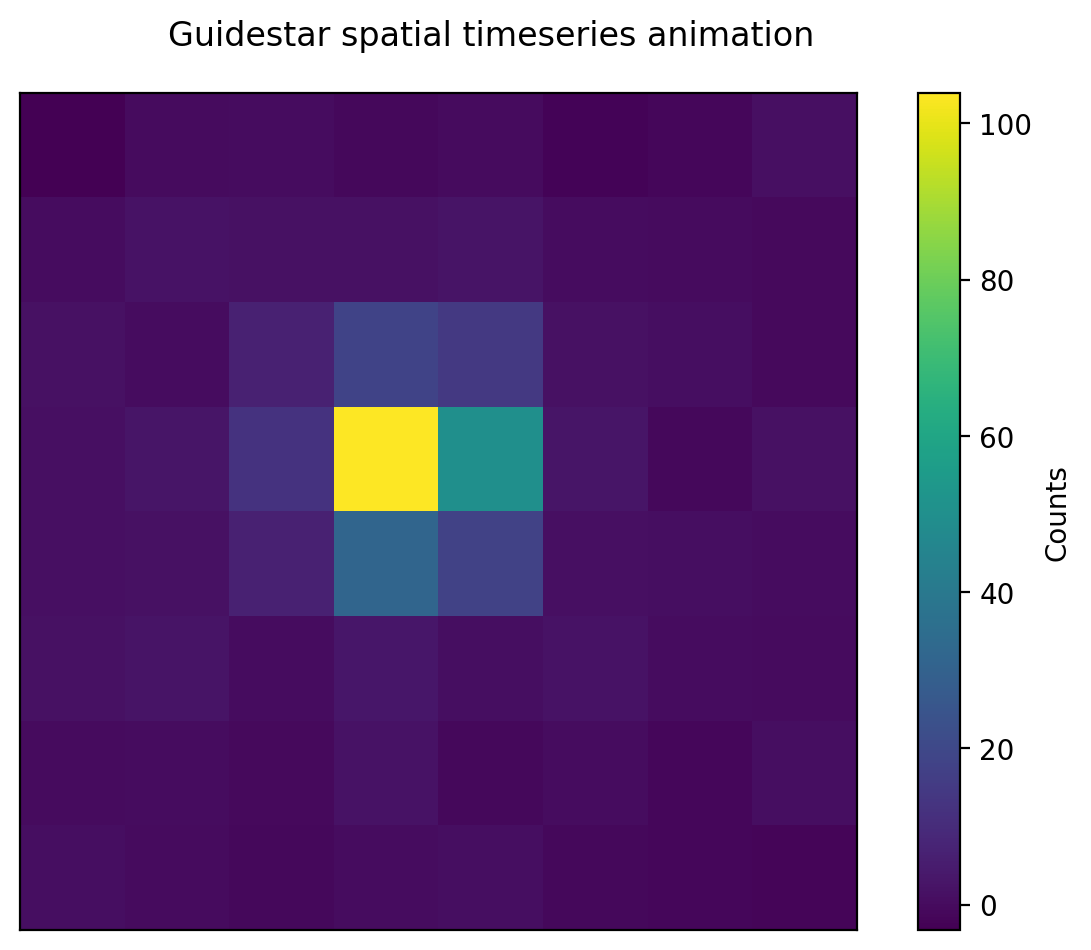

In [ ]:
spk.timelapse_animation(fg_array_2589[2150:2500]) # to save an animation with a filename, use *filename=*. Defaults to movie.gif

To get a side by side comparison of the evolution of a spatial timeseries and a parameter, use `flux_spatial_timelapse_animation`.

2023-07-18 11:13:24,531	INFO worker.py:1636 -- Started a local Ray instance.


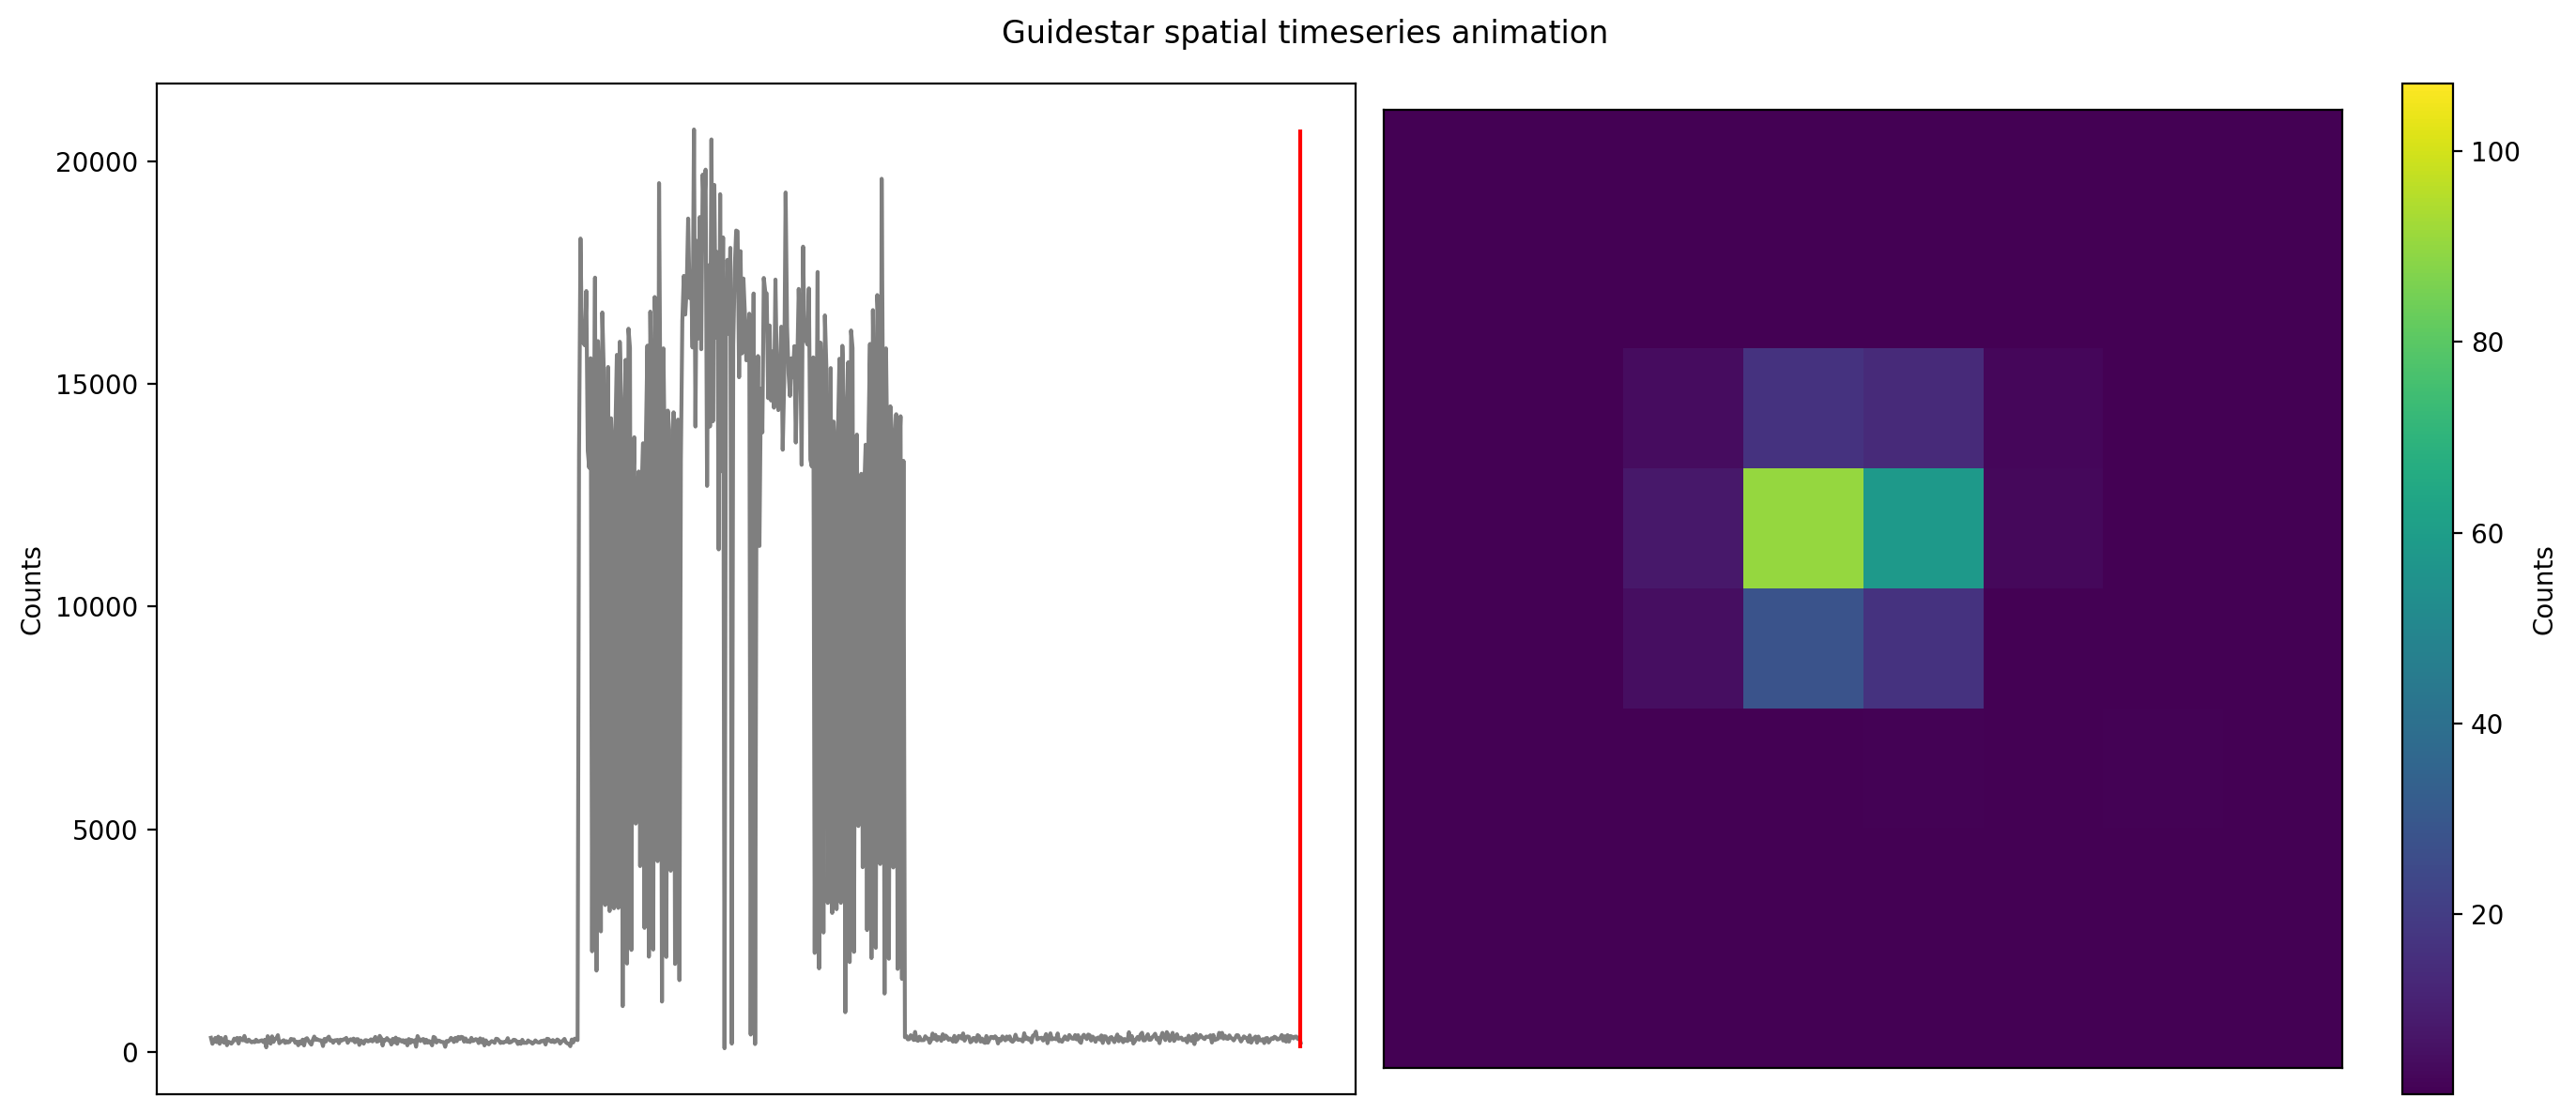

In [ ]:
filename = '/Users/ddeal/JWST-Treasure-Chest/quickstart.gif'
spk.flux_spatial_timelapse_animation(fg_array_2589, fg_flux_2589, start=1950, stop=2700, filename=filename)

![](/Users/ddeal/JWST-Treasure-Chest-2023/JWST-FGS-Spelunker-Repos/JWST-FGS-Spelunker/plots/quickstart.gif)

## Getting tables

After downloading a selected proposal id with `download`, we can easily output metadata about each downloaded file, including extracted data from the filename including `visit_group`, `parallel_sequence_id`, and `exposure_number`. The guide star used in each file is also included, as well as filter magnitudes and other stellar properties.

In [ ]:
spk.download('1534')

2023-07-18 11:19:08,895 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534001001_03101_00001_guider1/jw01534001001_gs-fg_2022340000825_cal.fits with expected size 9388800.
2023-07-18 11:19:08,951 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534001001_03101_00001_guider1/jw01534001001_gs-fg_2022340002102_cal.fits with expected size 7827840.
2023-07-18 11:19:09,008 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534001002_03101_00001_guider1/jw01534001002_gs-fg_2022340003651_cal.fits with expected size 8772480.
2023-07-18 11:19:09,060 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534001003_03101_00001_guider1/jw01534001003_gs-fg_2022340005224_cal.fits with expected size 8772480.


INFO: Found cached file ./mastDownload/JWST/jw01534001001_03101_00001_guider1/jw01534001001_gs-fg_2022340000825_cal.fits with expected size 9388800. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534001001_03101_00001_guider1/jw01534001001_gs-fg_2022340002102_cal.fits with expected size 7827840. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534001002_03101_00001_guider1/jw01534001002_gs-fg_2022340003651_cal.fits with expected size 8772480. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534001003_03101_00001_guider1/jw01534001003_gs-fg_2022340005224_cal.fits with expected size 8772480. [astroquery.query]


2023-07-18 11:19:09,114 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534001004_03101_00001_guider1/jw01534001004_gs-fg_2022340010755_cal.fits with expected size 8766720.
2023-07-18 11:19:09,205 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534002001_05101_00001_guider2/jw01534002001_gs-fg_2022338014704_cal.fits with expected size 10941120.
2023-07-18 11:19:09,262 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534002001_05101_00001_guider2/jw01534002001_gs-fg_2022338015941_cal.fits with expected size 7830720.
2023-07-18 11:19:09,313 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534002002_04101_00001_guider2/jw01534002002_gs-fg_2022338021919_cal.fits with expected size 10428480.


INFO: Found cached file ./mastDownload/JWST/jw01534001004_03101_00001_guider1/jw01534001004_gs-fg_2022340010755_cal.fits with expected size 8766720. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534002001_05101_00001_guider2/jw01534002001_gs-fg_2022338014704_cal.fits with expected size 10941120. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534002001_05101_00001_guider2/jw01534002001_gs-fg_2022338015941_cal.fits with expected size 7830720. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534002002_04101_00001_guider2/jw01534002002_gs-fg_2022338021919_cal.fits with expected size 10428480. [astroquery.query]


2023-07-18 11:19:09,412 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534002003_03101_00001_guider2/jw01534002003_gs-fg_2022338023521_cal.fits with expected size 8772480.
2023-07-18 11:19:09,485 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534002004_03101_00001_guider2/jw01534002004_gs-fg_2022338025056_cal.fits with expected size 8769600.
2023-07-18 11:19:09,560 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534003001_03101_00001_guider1/jw01534003001_gs-fg_2023125174543_cal.fits with expected size 9809280.


INFO: Found cached file ./mastDownload/JWST/jw01534002003_03101_00001_guider2/jw01534002003_gs-fg_2022338023521_cal.fits with expected size 8772480. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534002004_03101_00001_guider2/jw01534002004_gs-fg_2022338025056_cal.fits with expected size 8769600. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534003001_03101_00001_guider1/jw01534003001_gs-fg_2023125174543_cal.fits with expected size 9809280. [astroquery.query]


2023-07-18 11:19:09,629 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534003001_03101_00001_guider1/jw01534003001_gs-fg_2023125175812_cal.fits with expected size 7793280.
2023-07-18 11:19:09,686 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534003002_02101_00001_guider1/jw01534003002_gs-fg_2023125181351_cal.fits with expected size 8337600.
2023-07-18 11:19:09,740 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534003003_02101_00001_guider1/jw01534003003_gs-fg_2023125182911_cal.fits with expected size 8337600.
2023-07-18 11:19:09,796 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534003004_02101_00001_guider1/jw01534003004_gs-fg_2023125185519_cal.fits with expected size 8337600.


INFO: Found cached file ./mastDownload/JWST/jw01534003001_03101_00001_guider1/jw01534003001_gs-fg_2023125175812_cal.fits with expected size 7793280. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534003002_02101_00001_guider1/jw01534003002_gs-fg_2023125181351_cal.fits with expected size 8337600. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534003003_02101_00001_guider1/jw01534003003_gs-fg_2023125182911_cal.fits with expected size 8337600. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534003004_02101_00001_guider1/jw01534003004_gs-fg_2023125185519_cal.fits with expected size 8337600. [astroquery.query]


2023-07-18 11:19:09,849 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534004001_03101_00001_guider2/jw01534004001_gs-fg_2023123203053_cal.fits with expected size 12974400.
2023-07-18 11:19:09,904 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534004001_03101_00001_guider2/jw01534004001_gs-fg_2023123204330_cal.fits with expected size 7827840.
2023-07-18 11:19:09,953 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534004002_03101_00001_guider2/jw01534004002_gs-fg_2023123210335_cal.fits with expected size 8766720.
2023-07-18 11:19:10,032 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534004003_03101_00001_guider2/jw01534004003_gs-fg_2023123211905_cal.fits with expected size 8766720.


INFO: Found cached file ./mastDownload/JWST/jw01534004001_03101_00001_guider2/jw01534004001_gs-fg_2023123203053_cal.fits with expected size 12974400. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534004001_03101_00001_guider2/jw01534004001_gs-fg_2023123204330_cal.fits with expected size 7827840. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534004002_03101_00001_guider2/jw01534004002_gs-fg_2023123210335_cal.fits with expected size 8766720. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534004003_03101_00001_guider2/jw01534004003_gs-fg_2023123211905_cal.fits with expected size 8766720. [astroquery.query]


2023-07-18 11:19:10,085 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534004004_03101_00001_guider2/jw01534004004_gs-fg_2023123213436_cal.fits with expected size 8769600.


INFO: Found cached file ./mastDownload/JWST/jw01534004004_03101_00001_guider2/jw01534004004_gs-fg_2023123213436_cal.fits with expected size 8769600. [astroquery.query]


In [ ]:
spk.fg_table # We can simply call this attribute after using spk.download() to obtain our table!

filenames,sliced_directory,visit_group,parallel_sequence_id,activity_number,exposure_number,dir_seg,guider,obs_num,visit,reformed_directory,gs_id,guidestar_time,object_fg,hstID,gsc1ID,gsc2ID,GAIAdr1sourceID,GAIAdr2sourceID,ra,dec,epoch,raErr,decErr,posSource,rapm,decpm,rapmErr,decpmErr,deltaEpoch,pmSource,parallax,plxErr,plxSource,radialVelocity,rvErr,rvSource,classification,classSource,variableFlag,varSource,multipleFlag,multSource,gaiaGmag,gaiaGmagErr,gaiaGmagCode,gaiaRpmag,gaiaRpmagErr,gaiaRpmagCode,gaiaBpmag,gaiaBpmagErr,gaiaBpmagCode,OpgMag,OpgMagErr,OpgMagCode,JpgMag,JpgMagErr,JpgMagCode,VpgMag,VpgMagErr,VpgMagCode,FpgMag,FpgMagErr,FpgMagCode,EpgMag,EpgMagErr,EpgMagCode,NpgMag,NpgMagErr,NpgMagCode,UMag,UMagErr,UMagCode,UmagSource,BMag,BMagErr,BMagCode,BmagSource,VMag,VMagErr,VMagCode,VmagSource,RMag,RMagErr,RMagCode,RmagSource,IMag,IMagErr,IMagCode,ImagSource,SDSSuMag,SDSSuMagErr,SDSSuMagCode,SDSSuMagSource,SDSSgMag,SDSSgMagErr,SDSSgMagCode,SDSSgMagSource,SDSSrMag,SDSSrMagErr,SDSSrMagCode,SDSSrMagSource,SDSSiMag,SDSSiMagErr,SDSSiMagCode,SDSSiMagSource,SDSSzMag,SDSSzMagErr,SDSSzMagCode,SDSSzMagSource,PS1yMag,PS1yMagErr,PS1yMagCode,PS1ymagSource,tmassJMag,tmassJMagErr,tmassJMagCode,tmassJmagSource,tmassHMag,tmassHMagErr,tmassHMagCode,tmassHmagSource,tmassKsMag,tmassKsMagErr,tmassKsMagCode,tmassKsMagSource,VistaZMag,VistaZMagErr,VistaZMagCode,VistaZmagSource,VistaYMag,VistaYMagErr,VistaYMagCode,VistaYmagSource,VistaKMag,VistaKMagErr,VistaKMagCode,VistaKmagSource,WISEw1Mag,WISEw1MagErr,WISEw1MagCode,WISEw1MagSource,WISEw2Mag,WISEw2MagErr,WISEw2MagCode,WISEw2MagSource,WISEw3Mag,WISEw3MagErr,WISEw3MagCode,WISEw3MagSource,WISEw4Mag,WISEw4MagErr,WISEw4MagCode,WISEw4MagSource,FUVMag,FUVMagErr,FUVMagCode,FUVmagSource,NUVMag,NUVMagErr,NUVMagCode,NUVmagSource,gsc2semiMajorAxis,gsc2eccentricity,gsc2positionAngle,sourceStatus,mag,objID
str42,str33,int64,int64,int64,int64,int64,int64,int64,int64,str76,str10,float64,object,str11,str1,str14,object,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,object,int64,object,object,object,str1,str1,str1,int64,int64,str1,str1,str1,str1,float64,float64,int64,object,object,int64,object,object,int64,str1,str1,str1,str1,str1,str1,object,object,object,object,object,object,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,str1,str1,str1,str1,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,object,object,object,object,object,object,object,object,object,object,object,object,object,str1,object,object,str1,str1,str1,str1,str1,str1,str1,str1,object,object,object,int64,float64,int64
jw01534002001_gs-fg_2022338014704_cal.fits,jw01534002001_05101_00001_guider2,5,1,1,1,0,2,2,1,jw01534002001_05101_00001_guider2/jw01534002001_gs-fg_2022338014704_cal.fits,S1HP079555,59917.06639586805,"<GuiderCalModel(10752, 8, 8) from jw01534002001_gs-fg_2022338014704_cal.fits>",S1HP079555,,S013203179555,4658077781377287680,4658077781376437888,80.8375841177552,-69.5411237576133,2015.5,4.52984835071891e-05,5.04432730049479e-05,15,2.25376967153984,0.634072964088579,0.082398275042798,0.0959189966687397,9.70654,15,0.0767110514979857,0.0497606216596972,15,,,,0,15,,,,,16.1665725708008,0.0009902617,65,15.13784,0.003706293,66,16.88546,0.007711598,67,,,,,,,15.9169,0.430423,6,15.5987,0.43992,36,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,13.6590003967285,0.0280000008642673,47,9,12.8979997634888,0.0370000004768372,48,9,12.6899995803833,0.034000001847744,49,9,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,4.06971,0.340126,137.34,1000110502,16.1665725708008,2013203179555
jw01534002001_gs-fg_2022338015941_cal.fits,jw01534002001_05101_00001_guider2,5,1,1,1,0,2,2,1,jw01534002001_05101_00001_guider2/jw01534002001_gs-fg

We can obtain a neat DataFrame of each tracked guidestar, which gives us information such as the intergation start times and galactic coordinates.

In [ ]:
spk.object_properties

,guidestar_catalog_id,gaiadr1ID,gaiadr1ID,int_start,int_stop,ra,dec,Jmag,Hmag
0,S1HP079555,4658077781377287680,4658077781376437888,59917.066396,59917.074354,80.837584,-69.541124,13.659,12.898
1,S1HP080554,4658077991763987712,4658077991799023616,59917.089163,59917.096759,80.806837,-69.530972,15.001,14.282
2,S1HP078573,4657983910572904320,4657983910572904320,59917.112547,59917.118705,80.807043,-69.553474,13.839,13.078
3,S1HP079590,4657986831103727872,4657986835382982016,59918.999015,59919.005848,80.510790,-69.545479,15.410,14.839
4,S1HP079769,4657986831078120832,4657986835433225728,59919.019436,59919.025598,80.518235,-69.543415,15.231,14.341
5,S1HP078292,4657986796681532672,4657986801073794432,59919.041018,59919.047165,80.519564,-69.558464,12.804,11.883
6,S1HP077850,4657986762384054144,4657986766713867264,60067.871344,60067.877490,80.573531,-69.562862,12.957,12.227
7,S1HP197501,4657986865463528832,4657986869793061376,60067.882117,60067.888264,80.571447,-69.551750,13.063,12.168
8,S1HP773376,,4658078124973829632,60069.733171,60069.740086,80.794522,-69.504084,13.426,12.654
9,S1HP081366,4658078056254368128,4658078056254368128,60069.753592,60069.759620,80.758291,-69.524143,12.765,11.899
